# *Metagenome analysis pipeline part 2/2*

First run align.sh to align and normalize sequencing reads. Then use this to visualize the metagene pattern.

This pipeline is designed to be used primarily with small RNA sequencing data but can be adapted to all sequencing methods.

Inputs :
* bed file **or** directory with bed files
    * the form of bedfiles is as follows
        1. chrom (or gene)
        2. start pos of read
        3. end pos of read
        4. sequence of read
        5. abundance of the read
        6. strand
* transcript fasta file or bed windows
    * if using bed windows reads that fall witin these windows will be counted, if scaling is enabled the size of the window will be used for scaling.
        * Format 
            1. chrom (or gene)
            2. start 
            3. end
    * if transcript fasta file is provided but not bed windows, the length of the transcripts will be used for scaling.
    
Other parameters : 
* scaling --> default is True
* sample --> if None will use basename of bed file with reads.
* 5' nucleotide (p5nt) --> G or A
* min_len --> 21 nt
* max_len --> 23 nt


Tip :  
* use %%bash in cell to reformat bed.tsv file from output of nextflow_smRNA pipeline

**If using bed directory with bed files, use run_metagene_multi(), otherwise can use run_metagene()**

In [2]:
import os
import sys
import pandas as pd 
import argparse
import numpy as np 
import glob
import time 
import logging
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

def summarise_target_transcripts(bed_file) :
    
    bed = pd.read_csv(bed_file, 
                    sep = "\t",
                    usecols = [0,1,2,6,7,8],
                    names = ['chrom', 'start', 'end', 'transcript_start', 'transcript_end', 'ee_junc'])

    print(bed.head())
    
    bed = bed.query("transcript_end < 10000")

    print(f"Mean transcript length: {bed['transcript_end'].mean()}")

    print(f"Median transcript length: {bed['transcript_end'].median()}")
    
    fig, ax =plt.subplots(1,2)
    
    p = sns.histplot(data=bed, x="transcript_end", ax=ax[0])
    
    bed['scaled_ee_junc'] = 100*(bed['ee_junc'] / bed['transcript_end'])
    
    
    p1 = sns.histplot(data=bed, x="scaled_ee_junc", ax=ax[1])
    fig.show()

def plot_metagene(result, plot_group = 'alias', facet_by = None, x_col = 'pos', y_col = 'count', shade = None, title = None, sharey = False, vline = False, ylim = None) : 
    
    
    
    plot = sns.FacetGrid(result, 
                         col = facet_by, 
                         hue = plot_group, 
                         height = 4, 
                         aspect = 1)

    plot.map(sns.lineplot, x_col, y_col)
        
    plot.add_legend()
    
    if shade : 
            result['m'] = result[y_col] - result[shade]
            result['M'] = result[y_col] + result[shade]
            plot.map(plt.fill_between, x_col, 'm', 'M', alpha=0.2)
            
    if vline : 
        plt.axvline(x = vline, color = 'grey', label = f'{vline} bp', alpha = 0.5)
    
    
    if title : 
        plot.fig.suptitle(f'{title}')
        
    if ylim : 
        plot.set(ylim=(0, ylim))
    
    return plot

def merge_and_plot(conditions, result, count = 'count', vline = False, ylim = None, facet_by = 'type') :
    
    result_merge = result.merge(
        conditions, how = 'left', left_on = 'alias', right_on = 'simple_name')
    
    result_grouped = result_merge.groupby(
        ['pos', 'type', 'condition']
    ).agg(
        M = (count, 'mean'),
        S = (count, 'std')
    ).reset_index()
    
    plot_metagene(result_grouped, 
                  shade = 'S', 
                  facet_by='type', 
                  x_col = 'pos', 
                  y_col = 'M', 
                  plot_group = 'condition',
                  vline = vline,
                  ylim = ylim
                 )
    
    return result_grouped

def parse_transcripts(transcripts) : 
    
    sizes = {}
    seqs = {}
    seq = ''
    i = 0
    with open(transcripts, 'r') as f : 
        for line in f :
            if line.startswith(">") :
                info = line.strip().replace(">","")
                if i == 1 :
                    seqs[info] = seq 
                    sizes[info] = len(seq)
                    seq = ''
                    i = 0
                i += 1
            else : 
                seq += line.strip()
                
    return seqs, sizes

def parse_windows(bed_windows) : 

    windows = {}
    with open(bed_windows, 'r') as f : 
        for line in f : 
            info = line.strip().split("\t")
            gene = info[0]
            start = int(info[1])
            end = int(round(float(info[2])))

            if gene in windows.keys() : 
                windows[gene].append([start, end])
            else : 
                windows[gene] = [ [start, end] ]
    return windows

def calculate_coverage(bed) : 
    
    bed_entries = 0 
    with open(bed, 'r') as f : 
        for line in f : 
            bed_entries += 1
    f.close()
    print(f"{bed_entries} total bed entries...")
    
    cov = {}
    bed_line = 0
    with open(bed, 'r') as f :
        for line in f : 
            if not (line.startswith('chrom')) and not (line.startswith("gene_name")) : 
                info = line.strip().split('\t')
                chrom = info[0]
                start = int(info[1])
                end = int(info[2])
                seq = str(info[3])
                count = float(info[4])
                
                # make a dict for each gene
                if not chrom in cov.keys() : 
                    cov[chrom] = {}
                
                for i in range(start, end + 1) :
                    if i in cov[chrom].keys() : 
                        cov[chrom][i] += ( count / len(seq) )
                    else : 
                        cov[chrom][i] = ( count / len(seq) )
                        
            bed_line += 1
            print(f'{bed_line} of {bed_entries} ({ round(( (bed_line)/(bed_entries) )*100,2) }%) total bed entries', end='\r')
    f.close() 
    
    pklf = f"{bed}.cov.pickle"
    with open(pklf, 'wb') as handle : 
        pickle.dump(cov, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return cov
    

def adjust_pos(pos) : 
    
    if not pos == 100 and not pos == 0 : 
        return pos
    elif pos == 100 : 
        return 99.8
    else : 
        return 0.2

def sum_metagene_count_per_gene(bed, windows = None, scaling = False, transcript_sizes = None, sample = None, p5nt = ['G', 'A'], min_len = 21, max_len = 23) :
    
    time1 = time.time()
        
    pklf = f"{bed}.cov.pickle"
    if not os.path.exists(pklf) : 
        cov = calculate_coverage(bed)
    else : 
        with open(pklf, 'rb') as handle : 
            cov = pickle.load(handle)
    
    sample = os.path.basename(bed).split(".")[0]

    counts = []
    genes = []
    if windows : 
        total_windows = len(windows.keys())
        tracker = 0
        for gene,win_coord in windows.items() :
            for sub_win in win_coord :
                if gene in cov.keys() :
                    val = sum( [v for k,v in cov[gene].items() if sub_win[0] <= k <= sub_win[1]])
                    if val :
                        win_size = sub_win[1] - sub_win[0] + 1
                        genes.append(f"{gene}_{sub_win[0]}_{sub_win[1]}")
                        counts.append(val/win_size)
                            
           # tracker += 1
            #print(f'{tracker} of {total_windows} ({ round(( (tracker)/(total_windows) )*100,2) }%) windows processed', end='\r')
    else : 
        total_genes = len(cov.keys())
        tracker = 0
        for gene,subdict in cov.items() :
            val = sum(list(subdict.values()))
            if val :
                if gene in count.keys() : 
                    print("Multiple windows for 1 gene...exiting")
                    return 0
                else : 
                    genes.append(gene)
                    counts.append(count)
    
    df = pd.DataFrame({
        'gene' : genes, 
        f'{sample}' : counts
    })
    df = df.drop_duplicates()
    return df


def calculate_metagene_coord(bed, windows = None, scaling = False, transcript_sizes = None, sample = None, p5nt = ['G', 'A'], min_len = 21, max_len = 23) :
    
    time1 = time.time()
        
    pklf = f"{bed}.cov.pickle"
    if not os.path.exists(pklf) : 
        cov = calculate_coverage(bed)
    else : 
        with open(pklf, 'rb') as handle : 
            cov = pickle.load(handle)
    
    positions = []
    counts = []
    if windows : 
        total_windows = len(windows.keys())
        tracker = 0
        for gene,win_coord in windows.items() :
            for sub_win in win_coord :
                if gene in cov.keys() : 
                    cov_sub = { k:v for k,v in cov[gene].items() if sub_win[0] <= k <= sub_win[1] }

                    if bool(cov_sub) : 
                        win_size = sub_win[1] - sub_win[0] + 1

                        if scaling :
                            cov_sub_scaled = [ [(round(100*( (k-sub_win[0])/win_size)*5)/5), v] for k,v in cov_sub.items() ] 
                        else :
                            cov_sub_scaled = [ [(k-sub_win[0]), v] for k,v in cov_sub.items() ]

                        positions.extend([ i[0] for i in cov_sub_scaled ])
                        counts.extend([ i[1]/total_windows for i in cov_sub_scaled ])
            tracker += 1
            print(f'{tracker} of {total_windows} ({ round(( (tracker)/(total_windows) )*100,2) }%) windows processed', end='\r')

                
    # if no windows are specified
    else :
        total_genes = len(cov.keys())
        tracker = 0
        for gene,subdict in cov.items() :
            if scaling : 
                positions.extend([ round(100*(i/transcript_sizes[gene])*5/5) for i in list(subdict.keys()) ])
            else : 
                positions.extend(list(subdict.keys()))
                
            counts.extend(list(subdict.values()))
            
            tracker += 1
            print(f'{tracker} of {total_genes} ({ round(( (tracker)/(total_genes) )*100,2) }%) transcripts processed', end='\r')
    
    
    df1 = pd.DataFrame({
        'pos' : positions,
        'count' : counts, 
        'alias' : sample, 
        'type' : 'density'
    })
    
    res = df1.groupby(['pos', 'alias', 'type'])['count'].sum().reset_index()
    
    res['zscore'] = 2**((res['count'] - res['count'].mean())/res['count'].std(ddof=0))
    
    if scaling :
        if windows : 
            res = res.query('pos < 100 & pos > 0')
            
    time2 = time.time() 
    print(f"Processing {os.path.basename(bed)} took {round(time2-time1, 3)} s.\n")
    
    return res


def run_metagene(bed_input, bed_windows = None, scaling = False, transcripts = None, sample = None, p5nt = ['G', 'A'], min_len = 21, max_len = 23) : 
    
    if bed_windows : 
        my_windows = parse_windows(bed_windows)
    else : 
        my_windows = None
        
    if transcripts : 
        transcript_info = parse_transcripts(transcripts)
        transcript_sizes = transcript_info[1]
    else : 
        transcript_sizes = None
        
    bed_string = f".{os.path.basename(bed_windows).replace('.bed', '')}" if bed_windows is not None else ""
    
    if type(bed_input) is list : 
        for i,F in enumerate(bed_input) : 
            my_coords = calculate_metagene_coord(
                F, 
                windows = my_windows, 
                scaling = scaling, 
                transcript_sizes = transcript_sizes, 
                sample = os.path.basename(F).split(".")[0], 
                p5nt = p5nt,
                min_len = min_len, 
                max_len = max_len)
            
            if i == 0 :
                result = my_coords
            else : 
                result = pd.concat([result, my_coords], ignore_index=True)
        
        plot_metagene(result)
        return result
    else : 
        my_coords = calculate_metagene_coord(
            bed_input, 
            windows = my_windows, 
            scaling = scaling, 
            transcript_sizes = transcript_sizes, 
            sample = sample, 
            p5nt = p5nt,
            min_len = min_len, 
            max_len = max_len)
        
        plot_metagene(result, ycol = 'zscore', title = f'{bed_string}')    

def run_counting(bed_input, bed_windows = None, scaling = False, transcripts = None, sample = None, p5nt = ['G', 'A'], min_len = 21, max_len = 23) : 
    
    if bed_windows : 
        my_windows = parse_windows(bed_windows)
    else : 
        my_windows = None
        
    if transcripts : 
        transcript_info = parse_transcripts(transcripts)
        transcript_sizes = transcript_info[1]
    else : 
        transcript_sizes = None
        
    bed_string = f".{os.path.basename(bed_windows).replace('.bed', '')}" if bed_windows is not None else ""
    
    if type(bed_input) is list : 
        for i,F in enumerate(bed_input) : 
            me_counts = sum_metagene_count_per_gene(
                F, 
                windows = my_windows, 
                scaling = scaling, 
                transcript_sizes = transcript_sizes, 
                sample = os.path.basename(F).split(".")[0], 
                p5nt = p5nt,
                min_len = min_len, 
                max_len = max_len)
            
            if i == 0 :
                result = me_counts
            else : 
                result = result.merge(me_counts, how = 'outer', on = 'gene')
        
        return result
    else : 
        me_counts = sum_metagene_count_per_gene(
            bed_input, 
            windows = my_windows, 
            scaling = scaling, 
            transcript_sizes = transcript_sizes, 
            sample = sample, 
            p5nt = p5nt,
            min_len = min_len, 
            max_len = max_len)
        
        return me_counts

def pad_bedfile(bed) : 
    
    bed['start'] = bed.apply( lambda x : x['end']-100 if (x['end']-100) >= 0 else 0, axis = 1)
    
    bed['end'] = bed['end'] + 100
    
    #bed = bed[['gene', 'start', 'end']]
    
    
    return bed

def reformat_bedfile(directory) : 
    
    FILES = glob.glob(f"{directory}/*.bed.tsv")
    
    for F in FILES : 
        name = os.path.join(directory, os.path.basename(F).replace(".bed.tsv", ".rpm"))
        
        if not os.path.exists(name) :
            
            lines = ''
            with open(F, 'r') as f : 
                for line in f : 
                    info = line.strip().split("\t")
                    lines += f"{info[0]}\t{info[1]}\t{info[2]}\t{info[3]}\t{info[7]}\t{info[5]}\n"
            f.close()

            out = open(name, 'w')
            out.write(lines)
            out.close()

# CSR-1 IP analysis EJC

### Plot csr-1 and wago-9 IP data relative to exon-exon junctions on CSR-1 targets

In [3]:
os.getcwd()

'/fs/ess/PCON0160/ben/pipelines/metagene_analysis'

In [82]:
%%bash
# reformat bed.tsv file
dir=/fs/ess/PAS1473/znfx1_CSRIP_WAGO9IP/metagene_alignment/transcripts
outdir=$dir/reformat

[ ! -d $outdir ] && mkdir -p $outdir

for f in $(ls $dir/*.bed.tsv); do 
    
    name=$(basename $f .bed.tsv)
    cat $f |\
        awk -F'\t' '{OFS="\t"; print $1,$2,$3,$4,$8,$6}' > $outdir/$name.rpm

done


In [16]:
bed_input = "/fs/ess/PAS1473/znfx1_CSRIP_WAGO9IP/metagene_alignment/transcripts/reformat"

In [14]:
%%bash

cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.csr.processed.bed' | grep full_length > csr.full.bed
cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.hrde.processed.bed' | grep full_length > hrde.full.bed


In [ ]:
# full length 
csr = run_metagene(glob.glob(f"{bed_input}/*csr*.rpm"), 
             bed_windows = "csr.full.bed", 
             scaling = True,
             transcripts = None,
             sample = "upstream", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

wago = run_metagene(glob.glob(f"{bed_input}/*wago*.rpm"), 
             bed_windows = "hrde.full.bed", 
             scaling = True,
             transcripts = None,
             sample = "upstream", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

In [22]:
conditions = pd.read_csv("/fs/ess/PAS1473/znfx1_CSRIP_WAGO9IP/metagene_alignment/samples/replicates.csv", sep = ',')

In [24]:
csr.head()

,pos,alias,type,count
0,0.2,csr1_input_znfx1_1,density,1058.601422
1,0.4,csr1_input_znfx1_1,density,1946.929648
2,0.6,csr1_input_znfx1_1,density,2768.895583
3,0.8,csr1_input_znfx1_1,density,3050.142197
4,1.0,csr1_input_znfx1_1,density,3234.883538


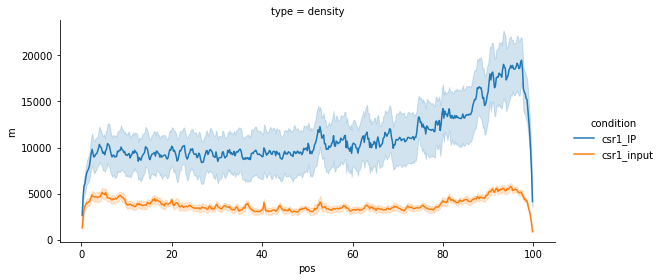

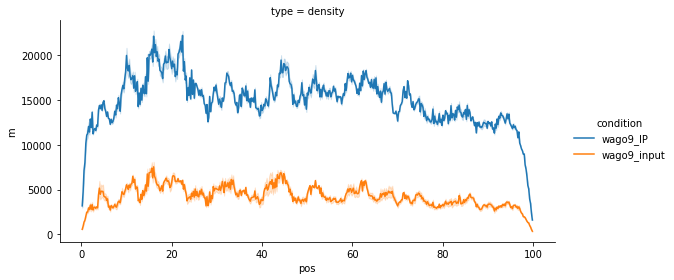

In [27]:
conditions = pd.read_csv("/fs/ess/PAS1473/znfx1_CSRIP_WAGO9IP/metagene_alignment/samples/replicates.csv", sep = ',')
merge_and_plot(conditions, csr.query('~alias.str.contains("IP_1") and ~alias.str.contains("znf")').reset_index(), count = 'count', vline = False)
merge_and_plot(conditions, wago.query('~alias.str.contains("IP_1") and ~alias.str.contains("znf")').reset_index(), count = 'count', vline = False)


### Calculate density in window per gene for CSR-1 targets

In [ ]:
%%bash

cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.csr.processed.bed' | grep -w upstream_last_exon > upstream_last_exon_csr.bed
cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.csr.processed.bed' | grep -w last_exon > last_exon_csr.bed
cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.csr.processed.bed' | grep -w three_prime_utr > three_prime_utr_csr.bed


cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.hrde.processed.bed' | grep -w upstream_last_exon > upstream_last_exon_hrde.bed
cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.hrde.processed.bed' | grep -w last_exon > last_exon_hrde.bed
cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.hrde.processed.bed' | grep -w three_prime_utr > three_prime_utr_hrde.bed


In [29]:
upstream_eejunc = run_counting(glob.glob(f"{bed_input}/*csr1*.rpm"), 
             bed_windows = "upstream_last_exon_csr.bed", 
             scaling = False,
             transcripts = None,
             sample = "upstream_last_exon", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

upstream_eejunc.to_csv("upstream_last_exon_csr.tsv", sep = "\t", header = True, index = False)

last_exon = run_counting(glob.glob(f"{bed_input}/*csr1*.rpm"), 
             bed_windows = "last_exon_csr.bed", 
             scaling = False,
             transcripts = None,
             sample = "last_exon", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

last_exon.to_csv("last_exon_csr.tsv", sep = "\t", header = True, index = False)

three_prime_utr_csr = run_counting(glob.glob(f"{bed_input}/*csr1*.rpm"), 
             bed_windows = "three_prime_utr_csr.bed", 
             scaling = False,
             transcripts = None,
             sample = "three_prime_utr", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

three_prime_utr_csr.to_csv("three_prime_utr_csr.tsv", sep = "\t", header = True, index = False)

In [30]:
upstream_eejunc = run_counting(glob.glob(f"{bed_input}/*csr1*.rpm"), 
             bed_windows = "upstream_last_exon_hrde.bed", 
             scaling = False,
             transcripts = None,
             sample = "upstream_last_exon", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

upstream_eejunc.to_csv("upstream_last_exon_hrde.tsv", sep = "\t", header = True, index = False)

last_exon = run_counting(glob.glob(f"{bed_input}/*csr1*.rpm"), 
             bed_windows = "last_exon_hrde.bed", 
             scaling = False,
             transcripts = None,
             sample = "last_exon", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

last_exon.to_csv("last_exon_hrde.tsv", sep = "\t", header = True, index = False)

three_prime_utr_csr = run_counting(glob.glob(f"{bed_input}/*csr1*.rpm"), 
             bed_windows = "three_prime_utr_hrde.bed", 
             scaling = False,
             transcripts = None,
             sample = "three_prime_utr", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

three_prime_utr_csr.to_csv("three_prime_utr_hrde.tsv", sep = "\t", header = True, index = False)

# Plot 22G parn-1 ; RdRP mutants

In [15]:
reformat_bedfile("/fs/ess/PCON0160/ben/projects/antisense_piRNA/metagene/transcripts/sample_rdrp")

In [32]:
%%bash

cat "/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/ce_ws279.linc.pseudo.pc.processed.bed" | grep -w full_length | grep -v WBGene00009052 | grep -v WBGene00001214 > all_genes.bed
cat "/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/ce_ws279.linc.pseudo.pc.csr.processed.bed" | grep -w full_length | grep -v WBGene00009052 | grep -v WBGene00001214 > csr.bed
cat "/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/ce_ws279.linc.pseudo.pc.wago.processed.bed" | grep -w full_length | grep -v WBGene00009052 | grep -v WBGene00001214 > wago.bed

Processing parn1ego1RNAi_1_S2_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 12.887 s.

Processing parn1_glh1_1_S23_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 26.845 s.

Processing N2_YD2.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 29.946 s.

Processing parn1_rrf1_redo_1_S21_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 19.227 s.

Processing parn1rde3_1_R1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 18.688 s.

Processing parnOxiYD_1_R1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 5.063 s.

Processing parn1_drh3_2_S20_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 20.353 s.

Processing parn_YD1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 25.824 s.

Processing parn1disl2_1_R1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 26.356 s.

Processing parn1-ekl1-RNAi-1_S4_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 13.885 s.



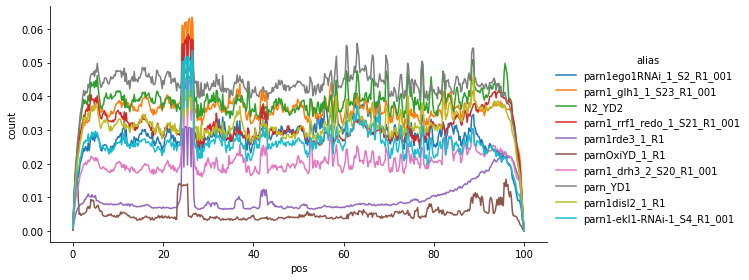

In [33]:
all_targets = run_metagene(glob.glob(f"{bed_input}/*.rpm"), 
             bed_windows = "all_genes.bed", 
             scaling = True,
             transcripts = None,
             sample = "upstream", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

Processing parn1ego1RNAi_1_S2_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 2.597 s.

Processing parn1_glh1_1_S23_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 4.191 s.

Processing N2_YD2.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 4.876 s.

Processing parn1_rrf1_redo_1_S21_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 3.032 s.

Processing parn1rde3_1_R1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 2.676 s.

Processing parnOxiYD_1_R1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 0.834 s.

Processing parn1_drh3_2_S20_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 3.334 s.

Processing parn_YD1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 4.222 s.

Processing parn1disl2_1_R1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 4.12 s.

Processing parn1-ekl1-RNAi-1_S4_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 2.407 s.



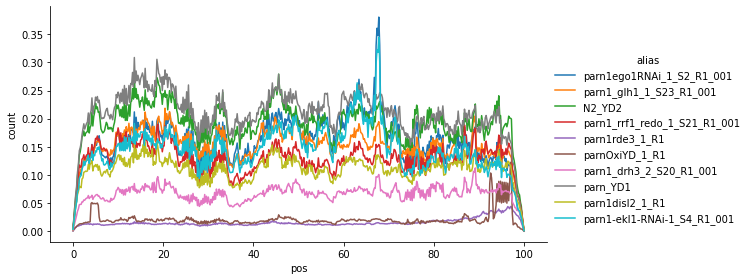

In [31]:
wago = run_metagene(glob.glob(f"{bed_input}/*.rpm"), 
             bed_windows = "wago.bed", 
             scaling = True,
             transcripts = None,
             sample = "upstream", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

Processing parn1ego1RNAi_1_S2_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 5.423 s.

Processing parn1_glh1_1_S23_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 15.426 s.

Processing N2_YD2.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 16.566 s.

Processing parn1_rrf1_redo_1_S21_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 11.196 s.

Processing parn1rde3_1_R1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 12.528 s.

Processing parnOxiYD_1_R1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 1.548 s.

Processing parn1_drh3_2_S20_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 10.821 s.

Processing parn_YD1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 14.184 s.

Processing parn1disl2_1_R1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 14.032 s.

Processing parn1-ekl1-RNAi-1_S4_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 6.399 s.



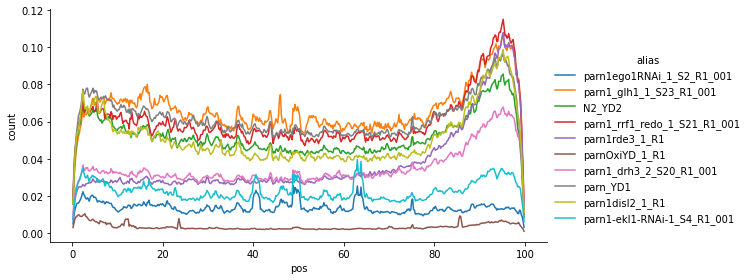

In [26]:
csr = run_metagene(glob.glob(f"{bed_input}/*.rpm"), 
             bed_windows = "csr.bed", 
             scaling = True,
             transcripts = None,
             sample = "upstream", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

# Parn-1 antisense project

In [15]:
def reformat_bedfile(directory) : 
    
    FILES = glob.glob(f"{directory}/*.bed.tsv")
    
    for F in FILES : 
        name = os.path.join(directory, os.path.basename(F).replace(".bed.tsv", ".rpm"))
        
        if not os.path.exists(name) :
            
            lines = ''
            with open(F, 'r') as f : 
                for line in f : 
                    info = line.strip().split("\t")
                    lines += f"{info[0]}\t{info[1]}\t{info[2]}\t{info[3]}\t{info[7]}\t{info[5]}\n"
            f.close()

            out = open(name, 'w')
            out.write(lines)
            out.close()


In [16]:
reformat_bedfile("/fs/ess/PCON0160/ben/projects/antisense_piRNA/metagene/transcripts/sample")

In [17]:
bed_input = "/fs/ess/PCON0160/ben/projects/antisense_piRNA/metagene/transcripts/sample"

conditions = pd.read_csv("/fs/ess/PCON0160/ben/projects/antisense_piRNA/metagene/samples/replicates.csv", sep = ',')

### PRG-1 targets

In [18]:
def filter_target_sites(targets, smRNA_bed, target_bed, seed_mm = 1, seed_gu = 2, other_mm = 3, other_gu = 2) : 
    
    tar = pd.read_csv(targets,
                      names = ['gene', 'start', 'end', 'smRNA', 'seq', 'strand', 'ref_seq', 'seed_mm', 'seed_gu', 'other_mm', 'other_gu'], 
                      header = 0, 
                      sep = "\t")
    
    # intersect smRNA bed to target bed, remove any target sites on targets that overlap with piRNAs
    cmd = f"sh intersect_targets_smRNA.sh {smRNA_bed} {target_bed} intersect.bed"
    os.system(cmd)
    
    genes = []
    with open('intersect.bed', 'r') as f : 
        for line in f : 
            info = line.strip().split("\t")
            genes.append(info[6])
    f.close()
    
    # filter targets that overlap with piRNAs
    #tar = tar.query('gene in @genes').reset_index(drop = True)
    
    # filter by mm 
    tar = tar.query('seed_mm <= @seed_mm and other_mm <= @other_mm and seed_gu <= @seed_gu and other_gu <= @other_gu').reset_index(drop = True)
    
    print(f"Total target sites: {tar.shape[0]}")
    print(tar.head())
    return tar

In [19]:
target_sites = filter_target_sites(
    targets = '/fs/ess/PCON0160/ben/projects/antisense_piRNA/target_sites.bed',
    smRNA_bed = '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/piRNA_26U.bed',
    target_bed = '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/c_elegans.PRJNA13758.WS279.gene.bed',
    seed_mm = 2, 
    seed_gu = 10,
    other_mm = 3,
    other_gu = 10
)


Total target sites: 4271
      gene  start   end       smRNA                         seq strand  \
0    CELE2    271   297  21ur-12794  TTTACGACAAAACTACGGTACCCGGT      -   
1  CEMUDR2    148   174   21ur-6124  TTGAAAAAGTTCCAAATTGGAAATCG      -   
2  CEMUDR2   1730  1756   21ur-2923  TGCTATTGTCTTTAATACAATAAAAA      -   
3     CER1     32    58   21ur-3296  TCGATATTCGAAATGACAAACTAGAA      -   
4     CER1   4109  4135   21ur-2690  TGATTGCCTTGCTTTTTTCATAAACT      -   

                      ref_seq  seed_mm  seed_gu  other_mm  other_gu  
0  tttgcgccaaaaatacggtacccggt        2        0         1         0  
1  tagcaaaagatcgaaattggaaaacg        2        0         3         0  
2  agctgttgtcttgaatgcaataataa        1        0         3         0  
3  tcgattttcgcaacgaaaaacgagaa        1        0         3         1  
4  tgatttccttgctcttttcatctaat        1        0         3         1  


## Plot everything

4270
Processing parn1_glh1_1_S23_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 2.292 s.

Processing TW282_17_uni.xc.v0.m1000.transcripts.rpm took 1.468 s.

Processing parn1_glh1_2_S24_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 2.06 s.

Processing TW292_17_uni.xc.v0.m1000.transcripts.rpm took 1.419 s.

Processing TW29_17_uni.xc.v0.m1000.transcripts.rpm took 1.21 s.

Processing TW281_17_uni.xc.v0.m1000.transcripts.rpm took 1.249 s.

None


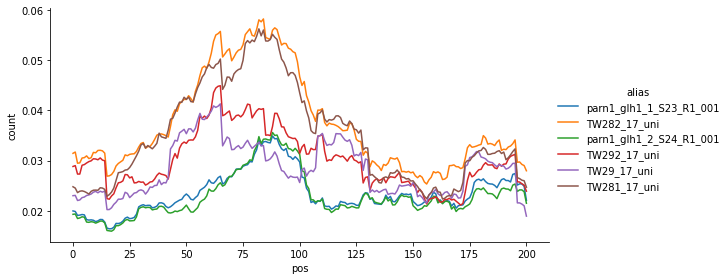

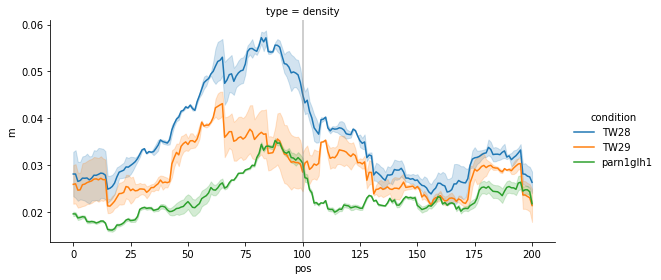

In [20]:
prg1_targets = pd.read_csv("/fs/ess/PCON0160/ben/projects/antisense_piRNA/parn1_prg1_targets.tsv", 
                          sep = "\t", 
                          names = ['gene'], 
                          header = None)

target_sites_prg1 = target_sites.query('gene != "WBGene00077437"').reset_index(drop = True) #[ target_sites['gene'].isin(prg1_targets.gene.tolist()) ].reset_index(drop = True)

target_sites_prg1_bed = pad_bedfile(target_sites_prg1)

target_sites_prg1_bed.to_csv("target_sites_prg1.bed", sep = "\t", header = False, index = False)

print( target_sites_prg1_bed.shape[0] )

prg1 = run_metagene(glob.glob(f"{bed_input}/*.rpm"), 
             bed_windows = "target_sites_prg1.bed", 
             scaling = False,
             transcripts = None,
             sample = "prg1", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

print( merge_and_plot(conditions, prg1, count = 'count', vline = 100) )

## Plot target sites for top 25% of piRNAs by abundance in TW28 (parn-1)

Processing parn1_glh1_1_S23_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 1.403 s.

Processing TW282_17_uni.xc.v0.m1000.transcripts.rpm took 0.973 s.

Processing parn1_glh1_2_S24_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 1.327 s.

Processing TW292_17_uni.xc.v0.m1000.transcripts.rpm took 0.903 s.

Processing TW29_17_uni.xc.v0.m1000.transcripts.rpm took 0.814 s.

Processing TW281_17_uni.xc.v0.m1000.transcripts.rpm took 0.687 s.



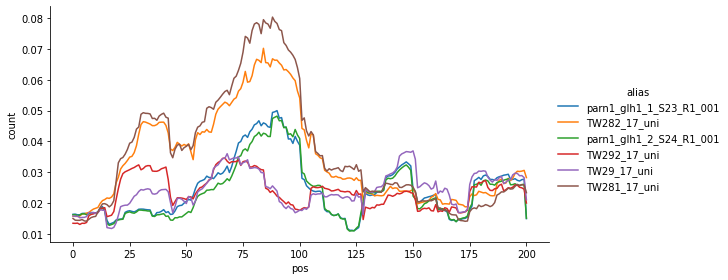

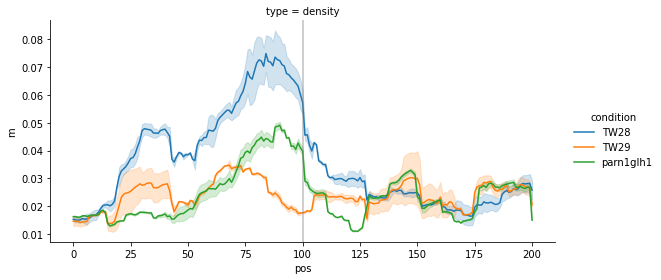

In [21]:
top_piRNA = pd.read_csv("/fs/ess/PCON0160/ben/projects/antisense_piRNA/top_25_piRNA_TW28.tsv", 
                          sep = "\t", 
                          names = ['gene'], 
                          header = None)

target_sites_prg1 = target_sites.query(
    'gene != "WBGene00077437"'
).query(
    'smRNA in @top_piRNA.gene.tolist()'
).reset_index(
    drop = True
)

target_sites_prg1_bed = pad_bedfile(target_sites_prg1)

target_sites_prg1_bed.to_csv("target_sites_prg1.bed", sep = "\t", header = False, index = False)

prg1 = run_metagene(glob.glob(f"{bed_input}/*.rpm"), 
             bed_windows = "target_sites_prg1.bed", 
             scaling = False,
             transcripts = None,
             sample = "prg1", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

merge_and_plot(conditions, prg1, count = 'count', vline = 100)

## Plot 22G density of target sites for bottom 25% of piRNAs by RPM

Processing parn1_glh1_1_S23_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 1.448 s.

Processing TW282_17_uni.xc.v0.m1000.transcripts.rpm took 1.003 s.

Processing parn1_glh1_2_S24_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 1.347 s.

Processing TW292_17_uni.xc.v0.m1000.transcripts.rpm took 0.909 s.

Processing TW29_17_uni.xc.v0.m1000.transcripts.rpm took 0.781 s.

Processing TW281_17_uni.xc.v0.m1000.transcripts.rpm took 0.691 s.



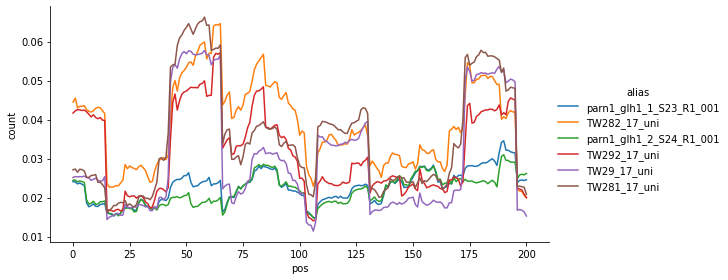

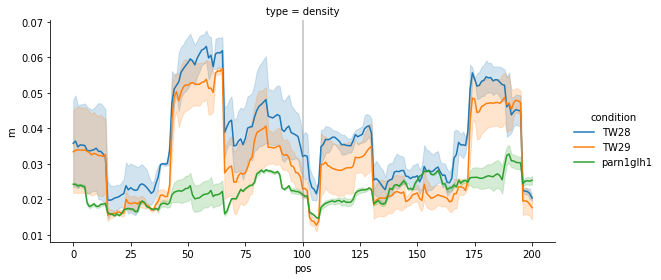

In [22]:
bottom_piRNA = pd.read_csv("/fs/ess/PCON0160/ben/projects/antisense_piRNA/bottom_25_piRNA_TW28.tsv", 
                          sep = "\t", 
                          names = ['gene'], 
                          header = None)

target_sites_prg1 = target_sites.query(
    'gene != "WBGene00077437"'
).query(
    'smRNA in @bottom_piRNA.gene.tolist()'
).reset_index(
    drop = True
)

target_sites_prg1_bed = pad_bedfile(target_sites_prg1)

target_sites_prg1_bed.to_csv("target_sites_prg1.bed", sep = "\t", header = False, index = False)

prg1 = run_metagene(glob.glob(f"{bed_input}/*.rpm"), 
             bed_windows = "target_sites_prg1.bed", 
             scaling = False,
             transcripts = None,
             sample = "prg1", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

merge_and_plot(conditions, prg1, count = 'count', vline = 100)

## Plot target sites for PRG-1 targets

395
Processing parn1_glh1_1_S23_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 1.366 s.

Processing TW282_17_uni.xc.v0.m1000.transcripts.rpm took 0.846 s.

Processing parn1_glh1_2_S24_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 1.249 s.

Processing TW292_17_uni.xc.v0.m1000.transcripts.rpm took 0.803 s.

Processing TW29_17_uni.xc.v0.m1000.transcripts.rpm took 0.681 s.

Processing TW281_17_uni.xc.v0.m1000.transcripts.rpm took 0.664 s.



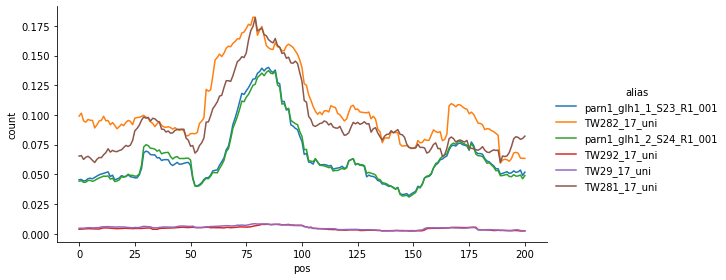

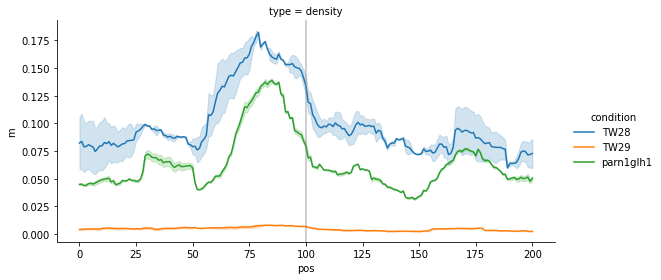

In [23]:
prg1_targets = pd.read_csv("/fs/ess/PCON0160/ben/projects/antisense_piRNA/parn1_prg1_targets.tsv", 
                          sep = "\t", 
                          names = ['gene'], 
                          header = None)

target_sites_prg1 = target_sites[ target_sites['gene'].isin(prg1_targets.gene.tolist()) ].reset_index(drop = True)

target_sites_prg1_bed = pad_bedfile(target_sites_prg1)

target_sites_prg1_bed.to_csv("target_sites_prg1.bed", sep = "\t", header = False, index = False)

print( target_sites_prg1_bed.shape[0] )

prg1 = run_metagene(glob.glob(f"{bed_input}/*.rpm"), 
             bed_windows = "target_sites_prg1.bed", 
             scaling = False,
             transcripts = None,
             sample = "prg1", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

merge_and_plot(conditions, prg1, count = 'count', vline = 100)

## Sum up 22G density at all piRNA target sites

In [380]:
pwd

'/fs/ess/PCON0160/ben/pipelines/metagene_analysis'

In [381]:
prg1_targets = pd.read_csv("/fs/ess/PCON0160/ben/projects/antisense_piRNA/parn1_prg1_targets.tsv", 
                          sep = "\t", 
                          names = ['gene'], 
                          header = None)

target_sites_prg1 = target_sites.query('gene != "WBGene00077437"').reset_index(drop = True) #[ target_sites['gene'].isin(prg1_targets.gene.tolist()) ].reset_index(drop = True)

target_sites_prg1_bed = pad_bedfile(target_sites_prg1)

target_sites_prg1_bed.to_csv("target_sites_prg1.bed", sep = "\t", header = False, index = False)

print( target_sites_prg1_bed.shape[0] )

density = run_counting(glob.glob(f"{bed_input}/*.rpm"), 
             bed_windows = "target_sites_prg1.bed", 
             scaling = False,
             transcripts = None,
             sample = "prg1", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

4270


In [384]:
target_sites_prg1_bed['target_site'] = target_sites_prg1_bed.apply(lambda x : f"{x.gene}_{x.start}_{x.end}", axis = 1)

target_site_piRNA = target_sites_prg1_bed[['target_site', 'smRNA']]


density.query('gene == "WBGene00021292_1012_1212"')


density_merge = density.fillna(0).merge(target_site_piRNA, how = 'left', left_on = 'gene', right_on = 'target_site').drop(columns = ['target_site'])



density_merge.to_csv("/fs/ess/PCON0160/ben/projects/antisense_piRNA/22G_density_piRNA_target_site.tsv", sep = "\t", header = True, index = False)



### Plot 22G density for piRNAs with antisense

In [24]:
with_anti = pd.read_csv("/fs/ess/PCON0160/ben/projects/antisense_piRNA/parn1_with_anti_id.tsv", 
                          sep = "\t")
with_anti.head()

,locus_id,parn1_prgip,antisense
0,21ur-3279,14.410253,True
1,21ur-3987,60.287793,True
2,21ur-2337,31.467287,True
3,21ur-3280,12.351645,True
4,21ur-783,3.823128,True


In [25]:
with_anti_t = with_anti.query('antisense == True').reset_index()
with_anti_f = with_anti.query('antisense == False').reset_index()

Processing parn1_glh1_1_S23_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 1.309 s.

Processing TW282_17_uni.xc.v0.m1000.transcripts.rpm took 0.814 s.

Processing parn1_glh1_2_S24_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 1.226 s.

Processing TW292_17_uni.xc.v0.m1000.transcripts.rpm took 0.83 s.

Processing TW29_17_uni.xc.v0.m1000.transcripts.rpm took 0.671 s.

Processing TW281_17_uni.xc.v0.m1000.transcripts.rpm took 0.597 s.



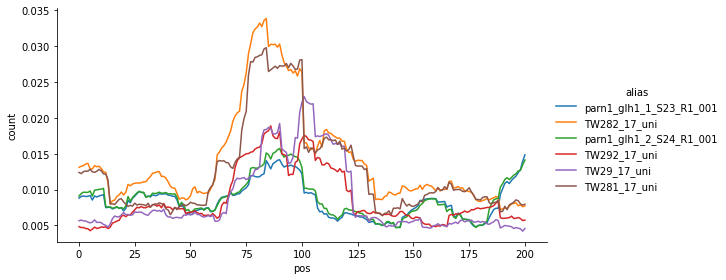

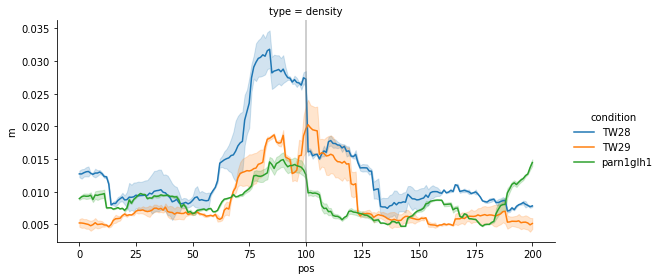

In [31]:
target_sites_prg1 = target_sites.query(
    'gene != "WBGene00077437"'
).query(
    'smRNA in @with_anti_t.locus_id.tolist()'
).reset_index(
    drop = True
)

target_sites_prg1_bed = pad_bedfile(target_sites_prg1)

target_sites_prg1_bed.to_csv("target_sites_prg1.bed", sep = "\t", header = False, index = False)

yes_antisense = run_metagene(glob.glob(f"{bed_input}/*.rpm"), 
             bed_windows = "target_sites_prg1.bed", 
             scaling = False,
             transcripts = None,
             sample = "prg1", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

yes_antisense_df = merge_and_plot(conditions, yes_antisense, count = 'count', vline = 100)

Processing parn1_glh1_1_S23_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 1.274 s.

Processing TW282_17_uni.xc.v0.m1000.transcripts.rpm took 0.809 s.

Processing parn1_glh1_2_S24_R1_001.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 1.224 s.

Processing TW292_17_uni.xc.v0.m1000.transcripts.rpm took 0.827 s.

Processing TW29_17_uni.xc.v0.m1000.transcripts.rpm took 0.666 s.

Processing TW281_17_uni.xc.v0.m1000.transcripts.rpm took 0.659 s.



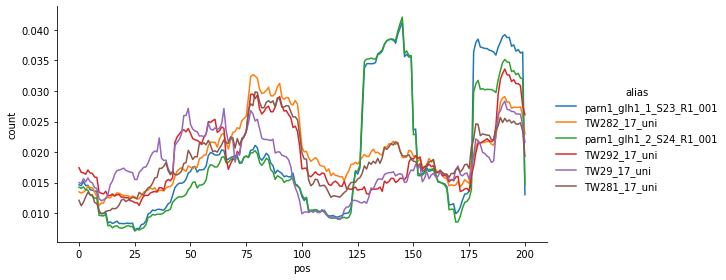

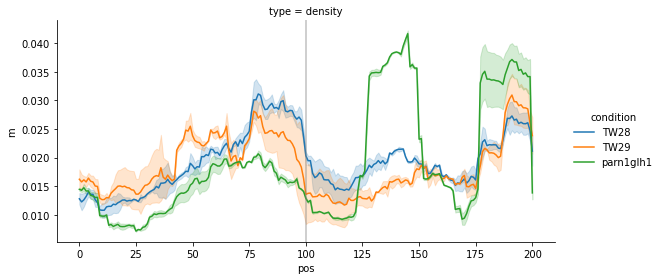

In [32]:
target_sites_prg1 = target_sites.query(
    'gene != "WBGene00077437"'
).query(
    'smRNA in @with_anti_f.locus_id.tolist()'
).reset_index(
    drop = True
)

target_sites_prg1_bed = pad_bedfile(target_sites_prg1)

target_sites_prg1_bed.to_csv("target_sites_prg1.bed", sep = "\t", header = False, index = False)

no_antisense = run_metagene(glob.glob(f"{bed_input}/*.rpm"), 
             bed_windows = "target_sites_prg1.bed", 
             scaling = False,
             transcripts = None,
             sample = "prg1", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

no_antisense_df = merge_and_plot(conditions, no_antisense, count = 'count', vline = 100)

In [51]:
yes_antisense_df['facet'] = 'yes_antisense'
no_antisense_df['facet'] = 'no_antisense' 

In [52]:
df = pd.concat([no_antisense_df, yes_antisense_df], ignore_index = True)

In [53]:
df

,pos,type,condition,M,S,m,facet
0,0,density,TW28,0.013788,0.000980,0.011828,no_antisense
1,0,density,TW29,0.017942,0.001714,0.014513,no_antisense
2,0,density,parn1glh1,0.014736,0.000281,0.014174,no_antisense
3,1,density,TW28,0.013730,0.001461,0.010809,no_antisense
4,1,density,TW29,0.017074,0.001311,0.014452,no_antisense
...,...,...,...,...,...,...,...
1201,199,density,TW29,0.005997,0.001053,0.003891,yes_antisense
1202,199,density,parn1glh1,0.014046,0.000349,0.013349,yes_antisense
1203,200,density,TW28,0.008003,0.000161,0.007681,yes_antisense
1204,200,density,TW29,0.005978,0.000824,0.004329,yes_antisense


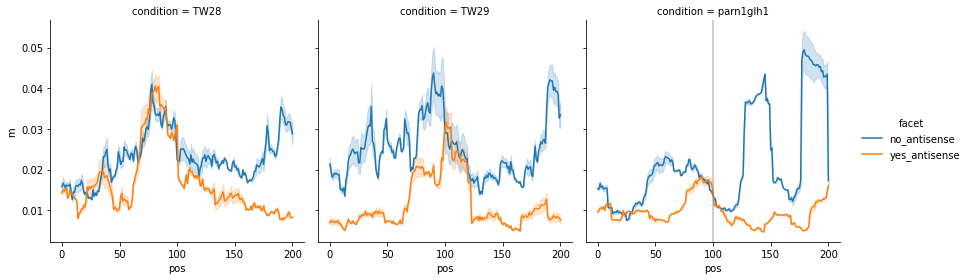

In [57]:
 plot_metagene(df, plot_group = 'facet', facet_by = "condition", x_col = 'pos', y_col = 'M', shade = 'S', title = None, sharey = False, vline = 100, ylim = None)